In [2]:
##################################
#                                #
# regression.ipynb               #
# Created 2023-07-26             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
data = pd.read_excel('AMR_imputation_Dec_2023.xlsx')

In [4]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data2019[(data2019['Piptaz_FINAL_imp']=='no_data')|(data2019['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data2019.shape[0]*100))

Missingness
Penicillin        2.42%
Amoxiclav        35.25%
Ampicillin        1.01%
Cloxacillin       6.52%
Piptaz            1.28%
Cefazolin         1.44%
Ceftriaxone       0.54%
Ceftazidime       0.87%
Ertapenem         1.58%
Meropenem         0.50%
Ciprofloxacin     1.31%
Levofloxacin     16.67%
Moxifloxacin      4.67%
Daptomycin        1.85%
Vancomycin        1.85%
Linezolid         1.85%
Amikacin          2.35%
Tobramycin        0.64%
Gentamicin        0.60%
Clindamycin       4.37%
Doxycycline      80.85%
Erythromycin     55.31%
TMPSMX            0.57%
Piptaz or tobra   1.38%


## Preprocessing

In [5]:
# Add a column for hospital site 
data2019['hosp_Sunnybrook'] = 1
data2019['hosp_TOH'] = 0
data2019['hosp_Trillium'] = 0

In [6]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Create a column for location of acquisition: community (1), ward (2), ICU (3)
# Created by summing Comm (1) vs. Hosp (2) and ICU acquisition (0 or 1)
data2019['Acquisition'] = data2019['Community(1), Hospital(2)'] + data2019['ICU Acquired']
data2019['Acquisition'] = data2019['Acquisition'].replace({1:'community',2:'ward',3:'ICU'})

# Change medical vs. surgical admitting service from 1/2 to 0/1
data2019['Medical(1) Surgical (2) Admitting Service'] = data2019['Medical(1) Surgical (2) Admitting Service'].replace({1:'medical',2:'surgical'})

# One hot encode categories
one_hot_data = pd.get_dummies(data2019, columns=['AgeCat','Sex','Acquisition','Medical(1) Surgical (2) Admitting Service'],
                                        prefix= ['age',   'sex','acquisition','adm_service'])

### Encode prior antibiotic exposure

In [7]:
# Create a column of prior exposure to either penicillins or aminoglycosides
conditions = [((one_hot_data['PriorPenicillin']==0) & (one_hot_data['PriorAMG']==0)),
              ((one_hot_data['PriorPenicillin']==1) | (one_hot_data['PriorAMG']==1))]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['PriorPenicillin_or_AMG'] = np.select(conditions, [0,1], default=-1)

# Create new categories of "prior non-[antibiotic class]"
one_hot_data['PriorNonCephalosporin'] = one_hot_data[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonCarbapenem'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonPenicillin'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonFQ'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonAMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonOtherAbx'] = one_hot_data[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

one_hot_data['PriorNonPenicillin_or_AMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorCarbapenem']].any(axis='columns')

one_hot_data

,Anonymous_ID,Episode,YearOfAdmission,"Community(1), Hospital(2)",ICU Acquired,ClincalMRAS,ClinicalVRE,ClinicalESBL,RecentHospitalization,ICUExposure,...,adm_service_medical,adm_service_surgical,PriorPenicillin_or_AMG,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx,PriorNonPenicillin_or_AMG
0,1,1,2008,2,0,0,0,0,0,0,...,True,False,1,True,True,False,True,True,True,False
1,1,2,2008,2,0,0,0,0,0,0,...,True,False,1,True,True,True,True,True,True,True
2,2,9,2011,2,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
3,3,15,2012,2,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
4,4,25,2013,2,0,0,0,0,0,0,...,True,False,1,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,2019,1,0,0,0,0,0,0,...,True,False,0,False,False,False,False,False,False,False
2972,2314,7215,2019,2,0,0,0,0,1,0,...,True,False,0,False,False,False,False,False,False,False
2973,2314,7215,2019,2,0,0,0,0,1,0,...,True,False,0,False,False,False,False,False,False,False
2974,2314,7216,2019,2,1,0,0,0,1,1,...,True,False,1,True,True,True,True,True,True,True


### List of antibiotics and classes to run regression on


In [8]:
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']
antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx','Piptaz_or_Tobramycin':'Penicillin_or_AMG'}

In [9]:
# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
one_hot_data['Piptaz_or_Tobramycin_FINAL_imp'] = (one_hot_data['Piptaz_FINAL_imp'])*(one_hot_data['Tobramycin_FINAL_imp'])

### Handling previous antibiotic exposure and resistance

In [10]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous gram negative organism without susceptibility data
        1 if previous susceptible gram negative organism
        2 if previous resistant gram negative organism 
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': return 0

    # 0 = prior susceptible, 1 = prior resistant
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==0): return 1
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==1): return 2
        
    else: raise ValueError('Inputs passed to the previous_infection function are invalid.')

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

In [11]:
# Special case of piperacillin-tazobactam plus tobramycin

    # 0 if no previous gram negative organism
    # 0 if previous gram negative organism without susceptibility data for either antibiotic
    # 1 if previous resistance to only one of the two antibiotics (the other may be susceptible or have no data)
    # 2 if previous resistance to both antibiotics

# Note that this behaviour is slightly different from the function for single antibiotic susceptibility histories,
    # which would assign a 1 if the previous antibiotic was susceptible

# 0 = prior susceptible, 1 = prior resistant
conditions = [(one_hot_data['PriorGNOrg']=='not_applicable'),              
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==0)),  
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==1))]
values = [0,0,0,0,0,1,1,1,1,2]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['Piptaz_or_TobramycinResistance'] = np.select(conditions, values, default=-1)

if 'Piptaz_or_Tobramycin' not in antibiotic_list:
    antibiotic_list.append('Piptaz_or_Tobramycin')

In [12]:
# Convert prior resistance history into one-hot encoding

for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data[antibiotic+'Resistance'].replace({0:'no_prior',
                                                                                           1:'susceptible',
                                                                                           2:'nonsusceptible'
                                                                                          })
    one_hot_data = pd.get_dummies(one_hot_data,columns=[antibiotic+'Resistance'])

In [13]:
list(one_hot_data)

['Anonymous_ID',
 'Episode',
 'YearOfAdmission',
 'Community(1), Hospital(2)',
 'ICU Acquired',
 'ClincalMRAS',
 'ClinicalVRE',
 'ClinicalESBL',
 'RecentHospitalization',
 'ICUExposure',
 'culture_test_cd',
 'PriorPenicillin',
 'PriorCephalosporin',
 'PriorCarbapenem',
 'PriorAMG',
 'PriorFQ',
 'PriorOtherAbx',
 'FINAL',
 'Penicillin_FINAL_imp',
 'Amoxiclav_FINAL_imp',
 'Ampicillin_FINAL_imp',
 'Cloxacillin_FINAL_imp',
 'Piptaz_FINAL_imp',
 'Cefazolin_FINAL_imp',
 'Ceftriaxone_FINAL_imp',
 'Ceftazidime_FINAL_imp',
 'Ertapenem_FINAL_imp',
 'Meropenem_FINAL_imp',
 'Ciprofloxacin_FINAL_imp',
 'Levofloxacin_FINAL_imp',
 'Moxifloxacin_FINAL_imp',
 'Daptomycin_FINAL_imp',
 'Vancomycin_FINAL_imp',
 'Linezolid_FINAL_imp',
 'Amikacin_FINAL_imp',
 'Tobramycin_FINAL_imp',
 'Gentamicin_FINAL_imp',
 'Clindamycin_FINAL_imp',
 'Doxycycline_FINAL_imp',
 'Erythromycin_FINAL_imp',
 'TMPSMX_FINAL_imp',
 'PriorGNOrg',
 'Penicillin_PGNO_imp',
 'Amoxiclav_PGNO_imp',
 'Ampicillin_PGNO_imp',
 'Cloxacillin_PGN

### Organisms isolated

In [14]:
one_hot_data['FINAL'].value_counts()

FINAL
Escherichia coli                                 1409
Klebsiella pneumoniae                             450
Pseudomonas aeruginosa                            423
Enterobacter cloacae                              141
Proteus mirabilis                                 132
Serratia marcescens                                64
Enterobacter aerogenes                             61
Klebsiella oxytoca                                 59
Citrobacter koseri                                 57
Citrobacter freundii                               37
Morganella morganii                                25
Stenotrophomonas maltophilia                       22
Acinetobacter baumannii                            14
Haemophilus influenzae                             12
Proteus penneri                                     8
Providencia stuartii                                7
Raoultella                                          7
Klebsiella species                                  5
Providencia rettgeri  

# Regression Function

In [15]:
regression_inputs = ['hosp_Sunnybrook','hosp_TOH', 
                     'age_40-45','age_45-50','age_50-55','age_55-60',
                     'age_60-65','age_65-70','age_70-75','age_75-80',
                     'age_80-85','age_85-90','age_>90',
                     'sex_M',
                     'acquisition_ICU','acquisition_ward',
                     'adm_service_surgical',
                     'RecentHospitalization','ICUExposure',
                     
                     'Prior[Class]Exposure','Prior[NonClass]Exposure',
                     '[Antibiotic]_susceptible','[Antibiotic]_nonsusceptible',
                     
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 24


In [16]:
list(one_hot_data)

['Anonymous_ID',
 'Episode',
 'YearOfAdmission',
 'Community(1), Hospital(2)',
 'ICU Acquired',
 'ClincalMRAS',
 'ClinicalVRE',
 'ClinicalESBL',
 'RecentHospitalization',
 'ICUExposure',
 'culture_test_cd',
 'PriorPenicillin',
 'PriorCephalosporin',
 'PriorCarbapenem',
 'PriorAMG',
 'PriorFQ',
 'PriorOtherAbx',
 'FINAL',
 'Penicillin_FINAL_imp',
 'Amoxiclav_FINAL_imp',
 'Ampicillin_FINAL_imp',
 'Cloxacillin_FINAL_imp',
 'Piptaz_FINAL_imp',
 'Cefazolin_FINAL_imp',
 'Ceftriaxone_FINAL_imp',
 'Ceftazidime_FINAL_imp',
 'Ertapenem_FINAL_imp',
 'Meropenem_FINAL_imp',
 'Ciprofloxacin_FINAL_imp',
 'Levofloxacin_FINAL_imp',
 'Moxifloxacin_FINAL_imp',
 'Daptomycin_FINAL_imp',
 'Vancomycin_FINAL_imp',
 'Linezolid_FINAL_imp',
 'Amikacin_FINAL_imp',
 'Tobramycin_FINAL_imp',
 'Gentamicin_FINAL_imp',
 'Clindamycin_FINAL_imp',
 'Doxycycline_FINAL_imp',
 'Erythromycin_FINAL_imp',
 'TMPSMX_FINAL_imp',
 'PriorGNOrg',
 'Penicillin_PGNO_imp',
 'Amoxiclav_PGNO_imp',
 'Ampicillin_PGNO_imp',
 'Cloxacillin_PGN


Logistic regression model for Cefazolin:

Logistic Regression Coefficients
CefazolinResistance_nonsusceptible          1.4527
ClinicalESBL                                1.0261
acquisition_ICU                             1.0212
PriorCephalosporin                          0.5720
sex_M                                       0.3760
adm_service_surgical                        0.2897
PriorNonCephalosporin                       0.2047
age_50-55                                   0.1229
age_45-50                                   0.1086
age_55-60                                   0.0825
acquisition_ward                            0.0242
hosp_TOH                                    0.0000
hosp_Sunnybrook                            -0.0003
age_75-80                                  -0.0172
age_60-65                                  -0.0526
RecentHospitalization                      -0.0715
ICUExposure                                -0.1474
age_70-75                                  -0.1758
age_40

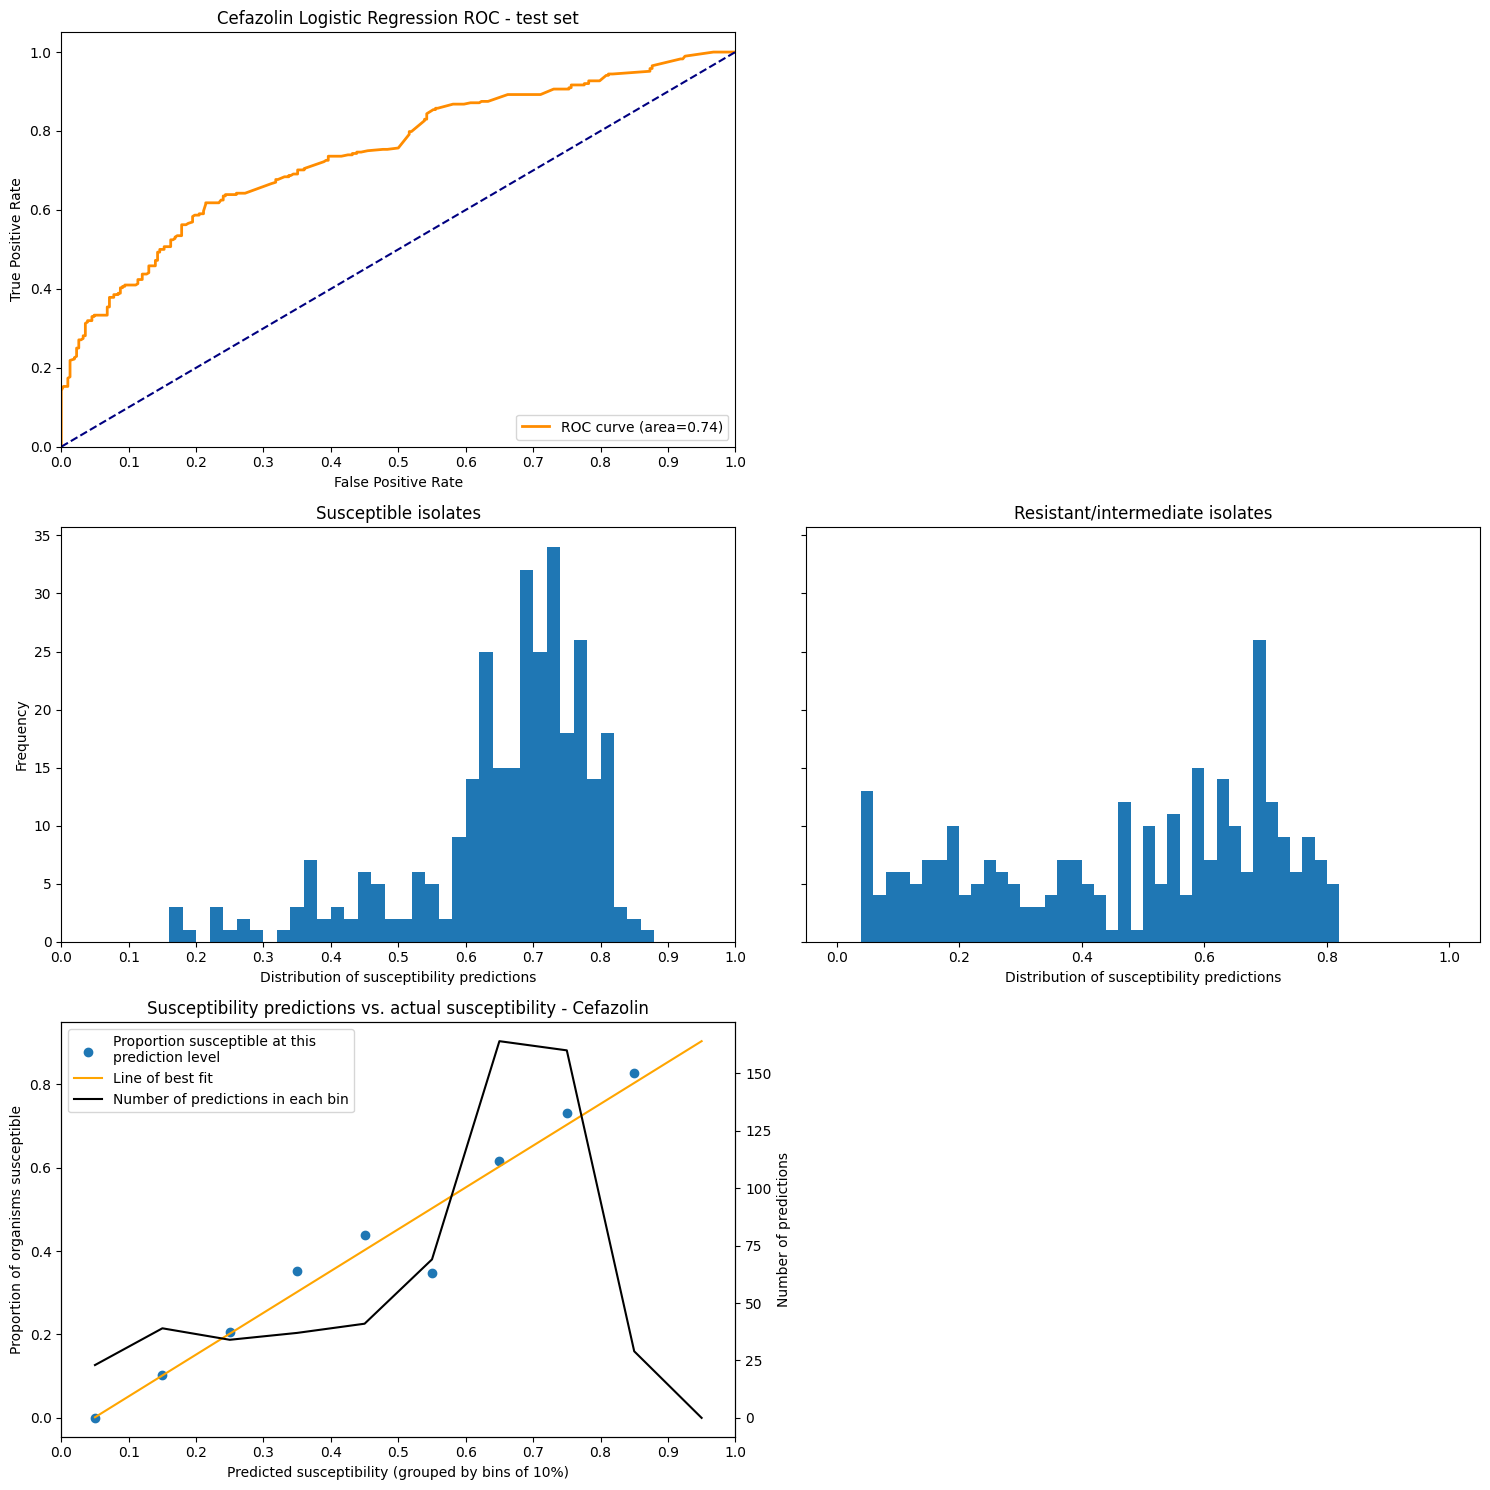


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
ClinicalESBL                                1.8434
CeftriaxoneResistance_nonsusceptible        1.7436
acquisition_ICU                             0.7312
PriorCephalosporin                          0.6678
PriorNonCephalosporin                       0.3142
sex_M                                       0.1226
adm_service_surgical                        0.1197
acquisition_ward                            0.1084
age_45-50                                   0.0050
age_50-55                                   0.0029
hosp_Sunnybrook                             0.0004
hosp_TOH                                    0.0000
RecentHospitalization                      -0.0059
age_55-60                                  -0.1689
age_75-80                                  -0.1894
ICUExposure                                -0.2180
age_60-65                                  -0.2242
age_65-70                                  -0.3852
age_

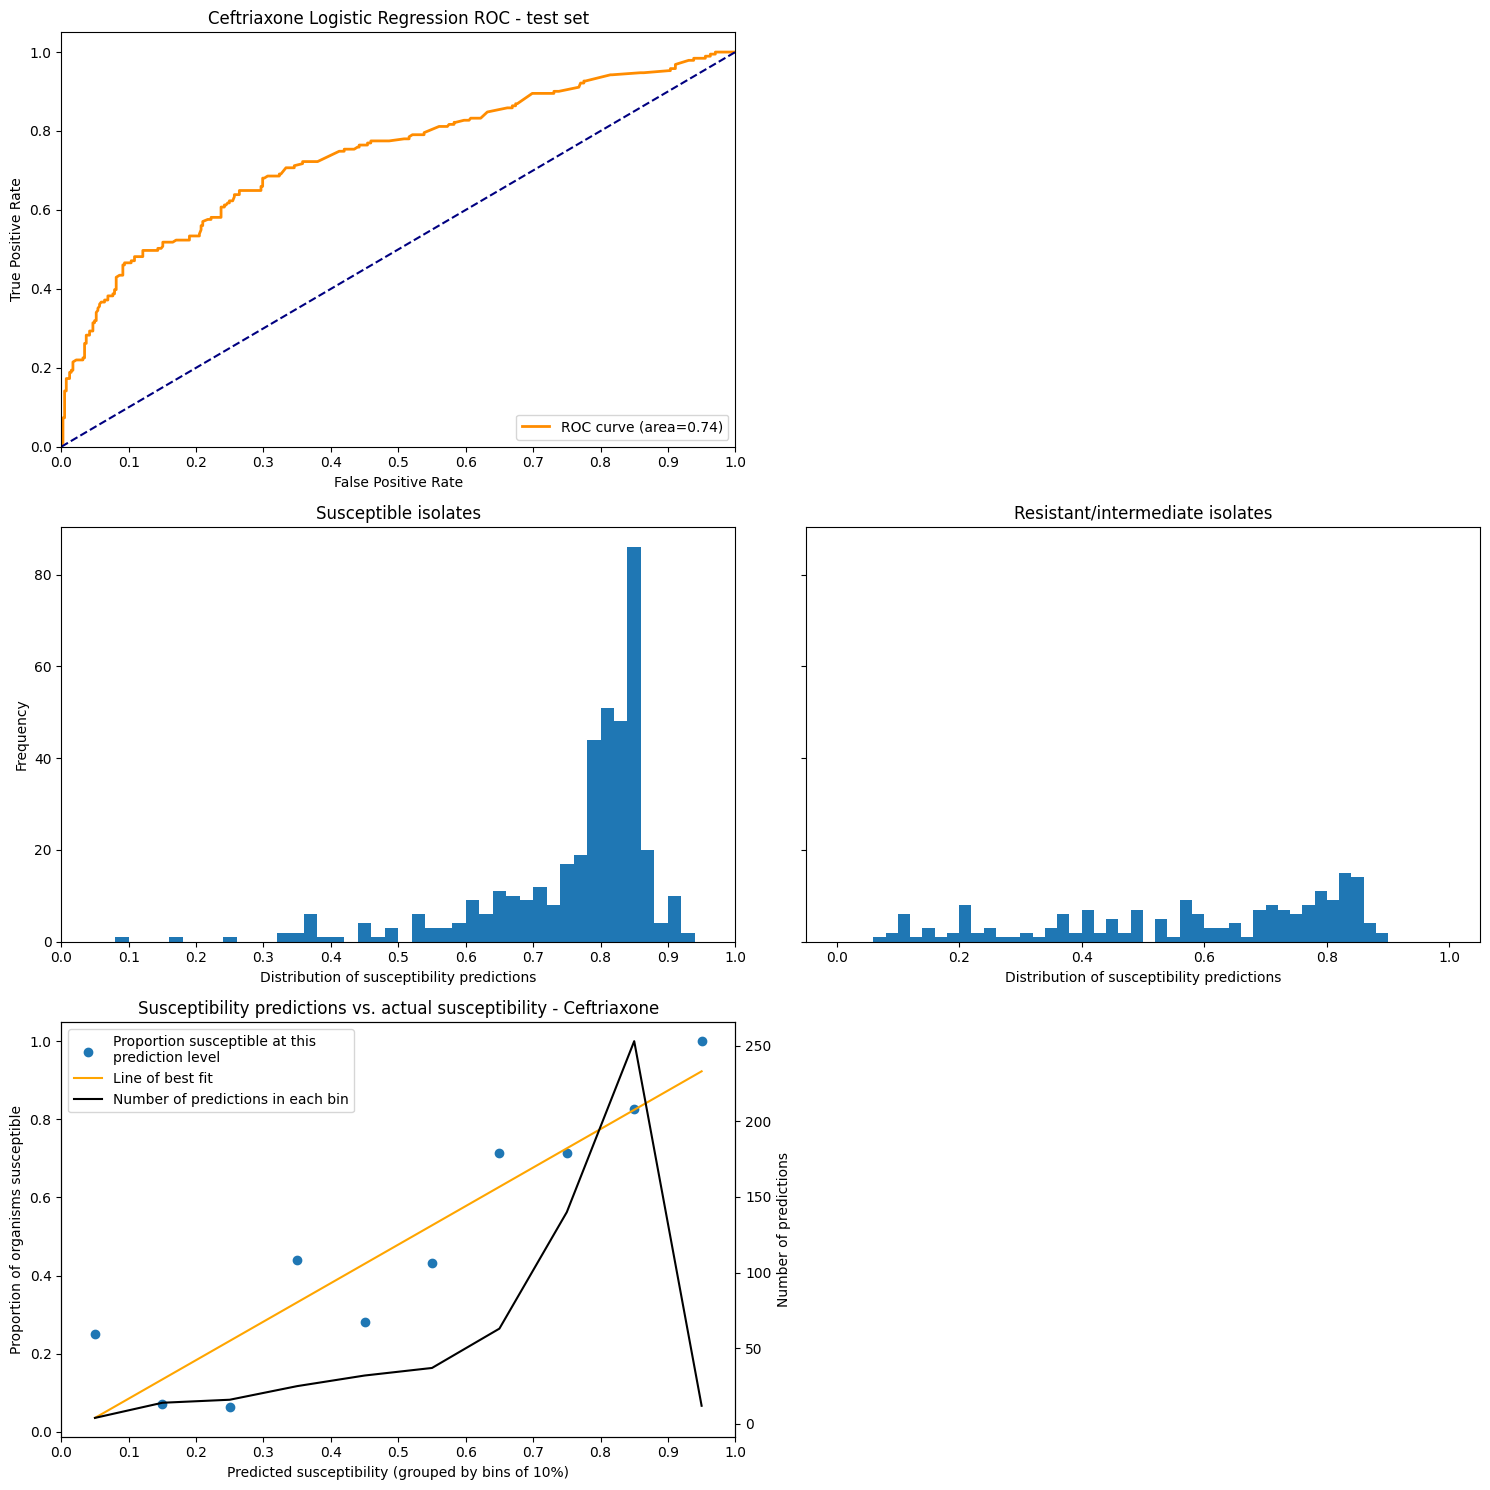


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
ClinicalESBL                                2.0775
CeftazidimeResistance_nonsusceptible        1.1506
PriorNonCephalosporin                       0.4346
PriorCephalosporin                          0.4191
acquisition_ICU                             0.3700
age_45-50                                   0.2176
adm_service_surgical                        0.1188
acquisition_ward                            0.1020
RecentHospitalization                       0.0621
hosp_Sunnybrook                             0.0011
hosp_TOH                                    0.0000
ICUExposure                                -0.0371
age_60-65                                  -0.0509
age_75-80                                  -0.0668
age_65-70                                  -0.1071
age_55-60                                  -0.1328
sex_M                                      -0.1363
age_50-55                                  -0.2568
age_

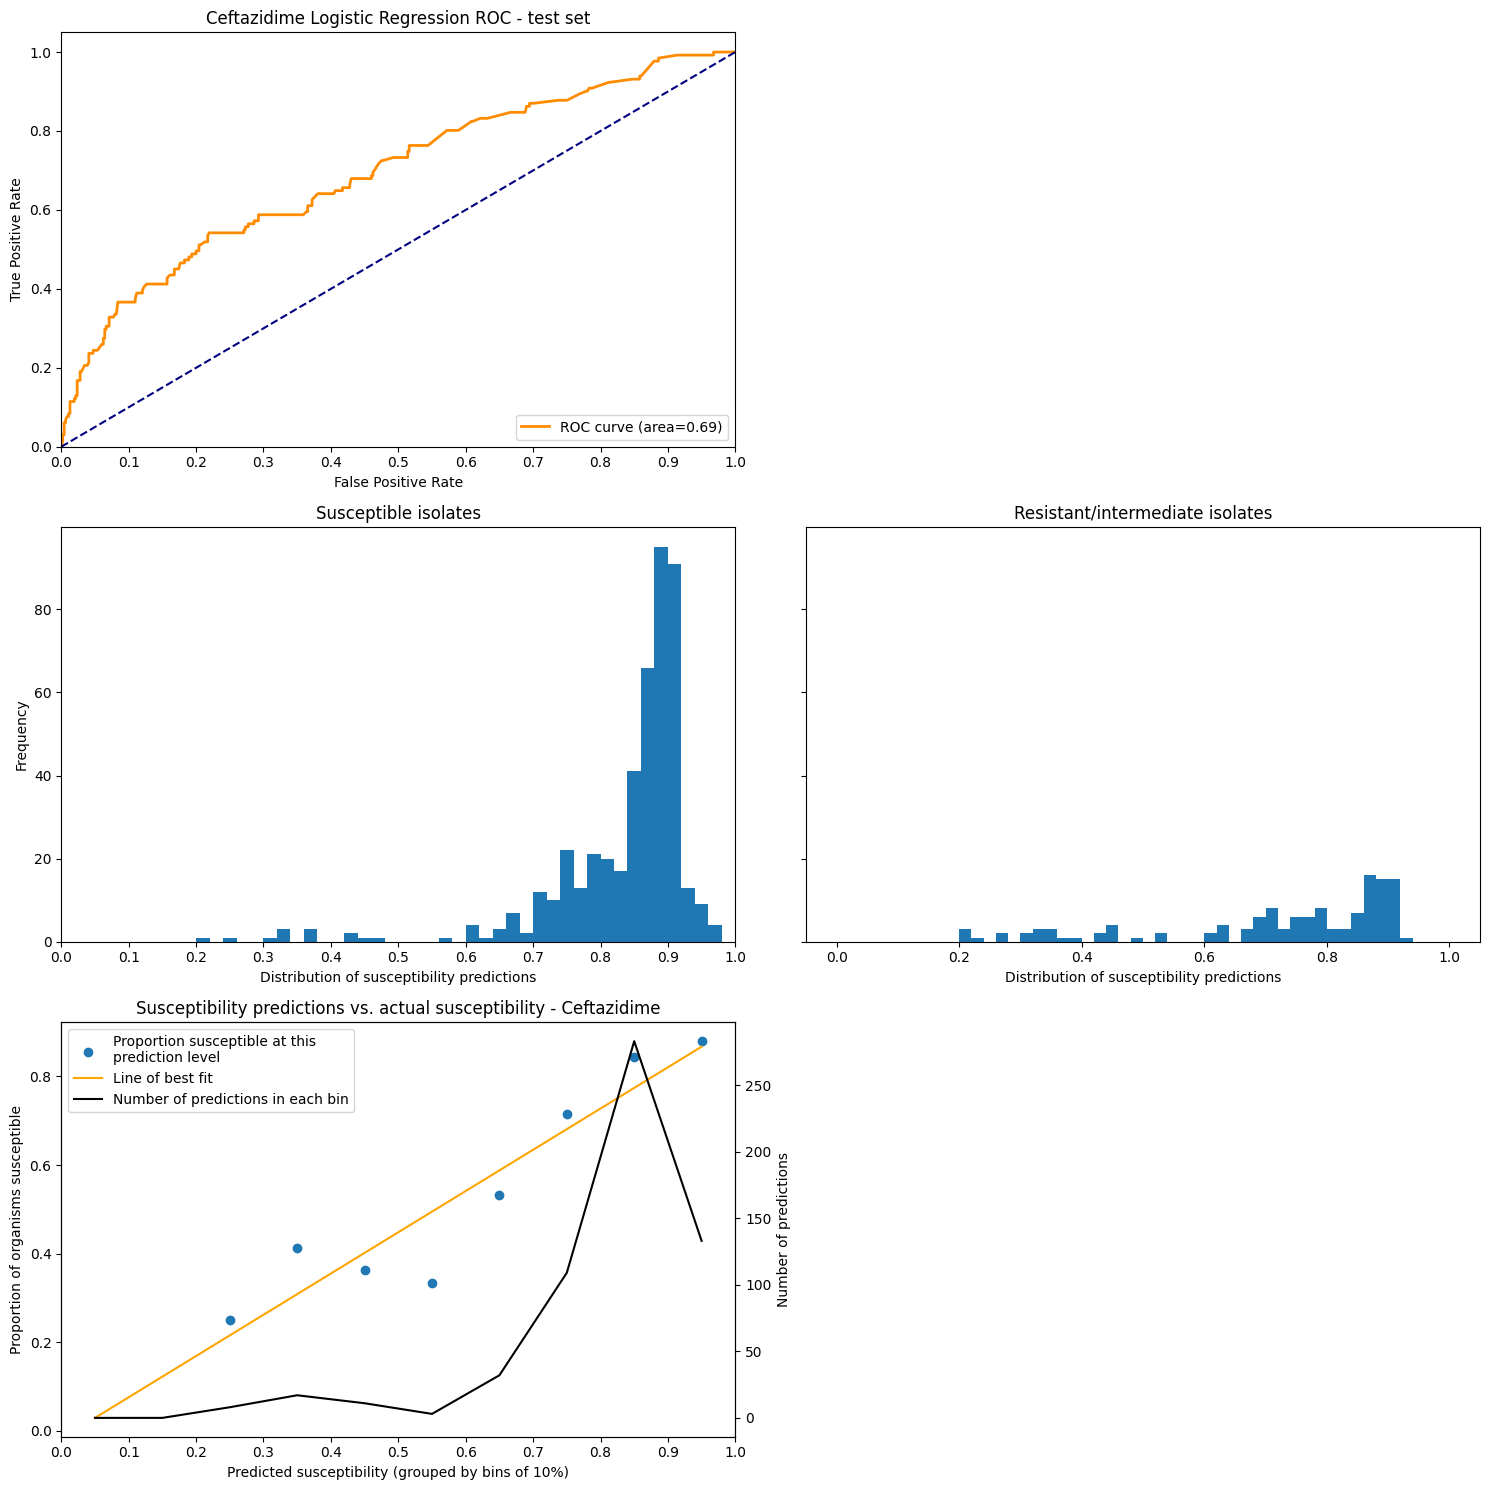


Logistic regression model for Piptaz:

Logistic Regression Coefficients
ClinicalESBL                                1.8238
PiptazResistance_nonsusceptible             0.9229
PriorNonPenicillin                          0.6399
PriorPenicillin                             0.4256
acquisition_ICU                             0.1749
adm_service_surgical                        0.1614
age_55-60                                   0.1546
age_60-65                                   0.0358
age_45-50                                   0.0171
acquisition_ward                            0.0053
hosp_Sunnybrook                             0.0001
hosp_TOH                                    0.0000
sex_M                                      -0.0142
ICUExposure                                -0.0353
age_75-80                                  -0.0476
age_65-70                                  -0.0965
RecentHospitalization                      -0.1367
age_50-55                                  -0.2559
age_70-75

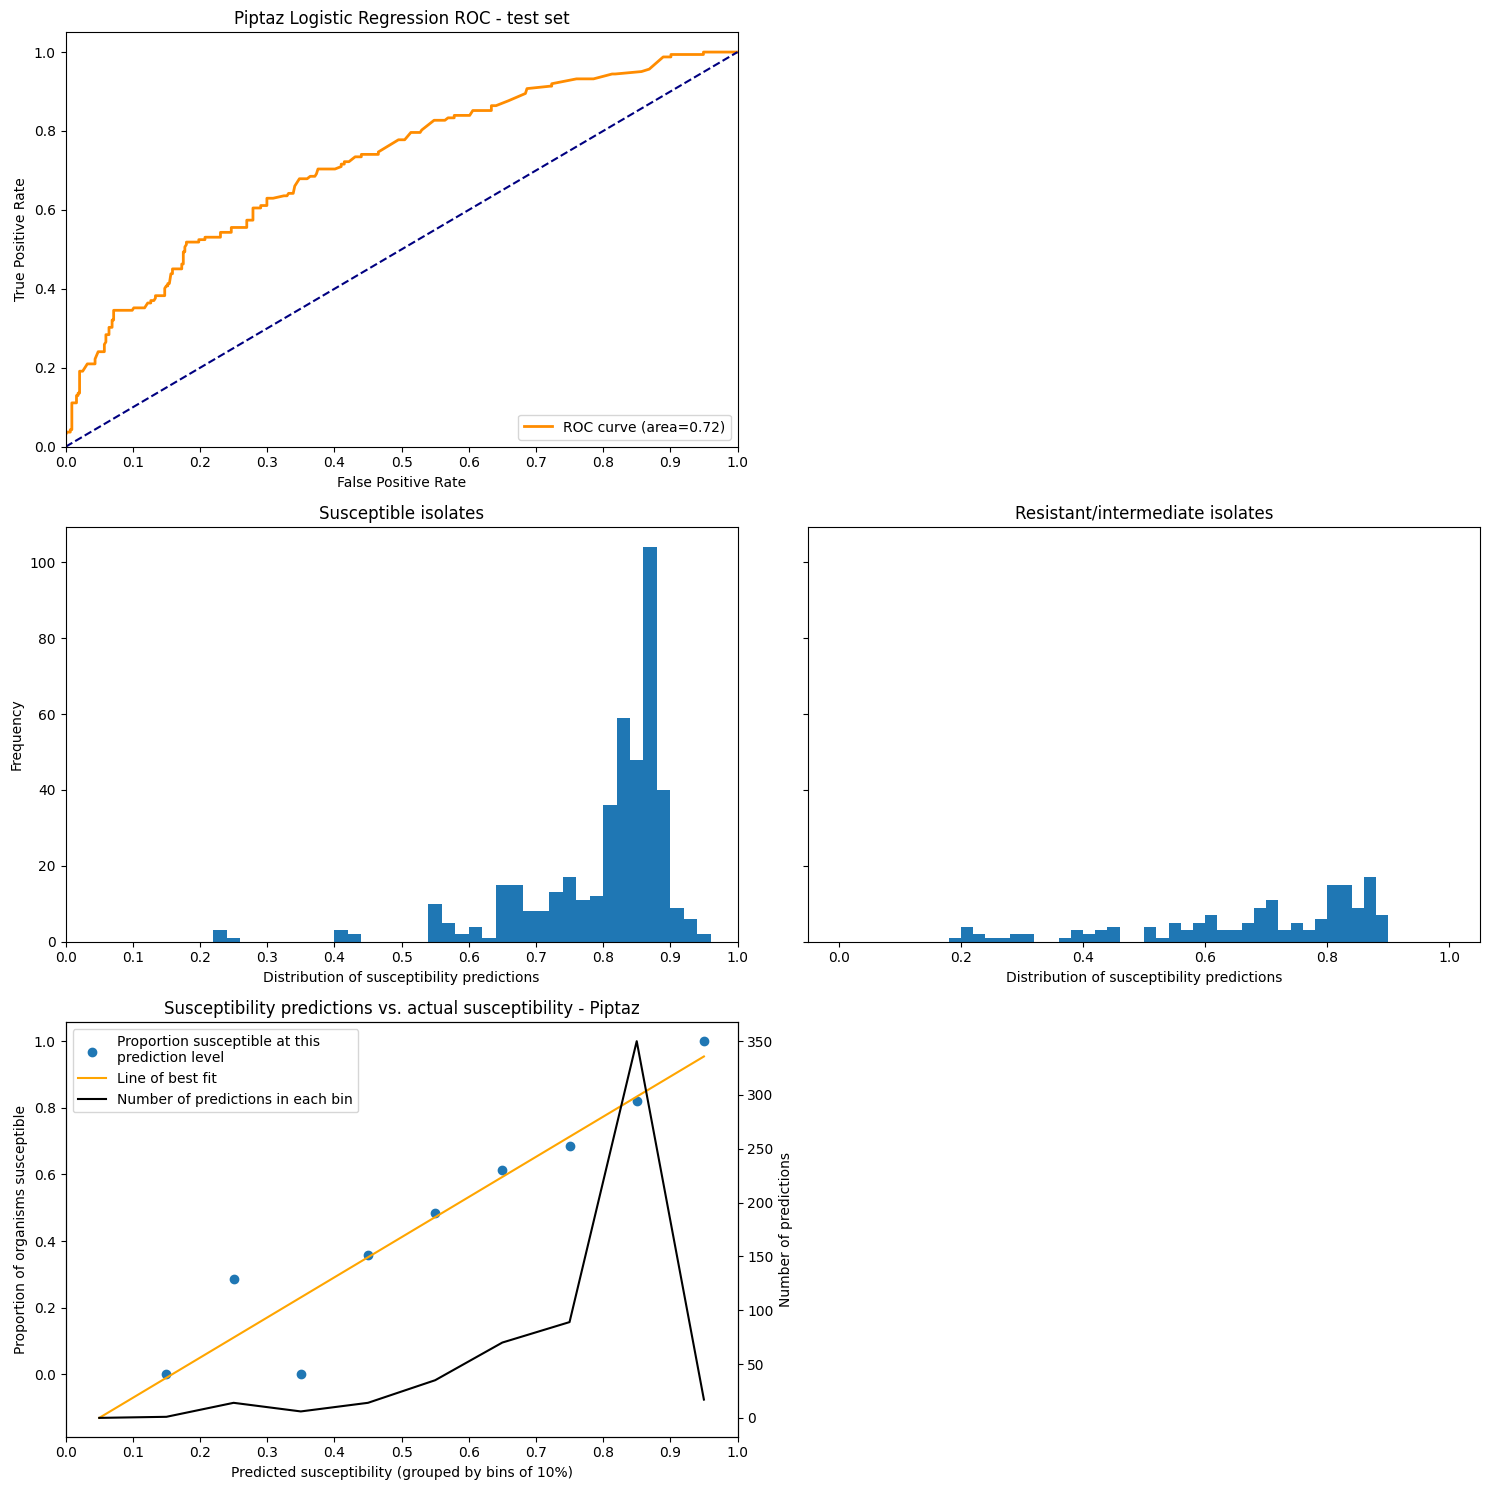


Logistic regression model for Meropenem:

Logistic Regression Coefficients
PriorCarbapenem                             2.2364
ClinicalESBL                                0.6026
MeropenemResistance_nonsusceptible          0.4843
acquisition_ICU                             0.3947
PriorNonCarbapenem                          0.2281
sex_M                                       0.1900
ICUExposure                                 0.1675
age_45-50                                   0.0918
hosp_TOH                                    0.0000
hosp_Sunnybrook                            -0.0001
acquisition_ward                           -0.0179
age_40-45                                  -0.0470
age_60-65                                  -0.2064
adm_service_surgical                       -0.2995
RecentHospitalization                      -0.5316
age_75-80                                  -0.5458
age_70-75                                  -0.6053
age_80-85                                  -0.7772
age_65

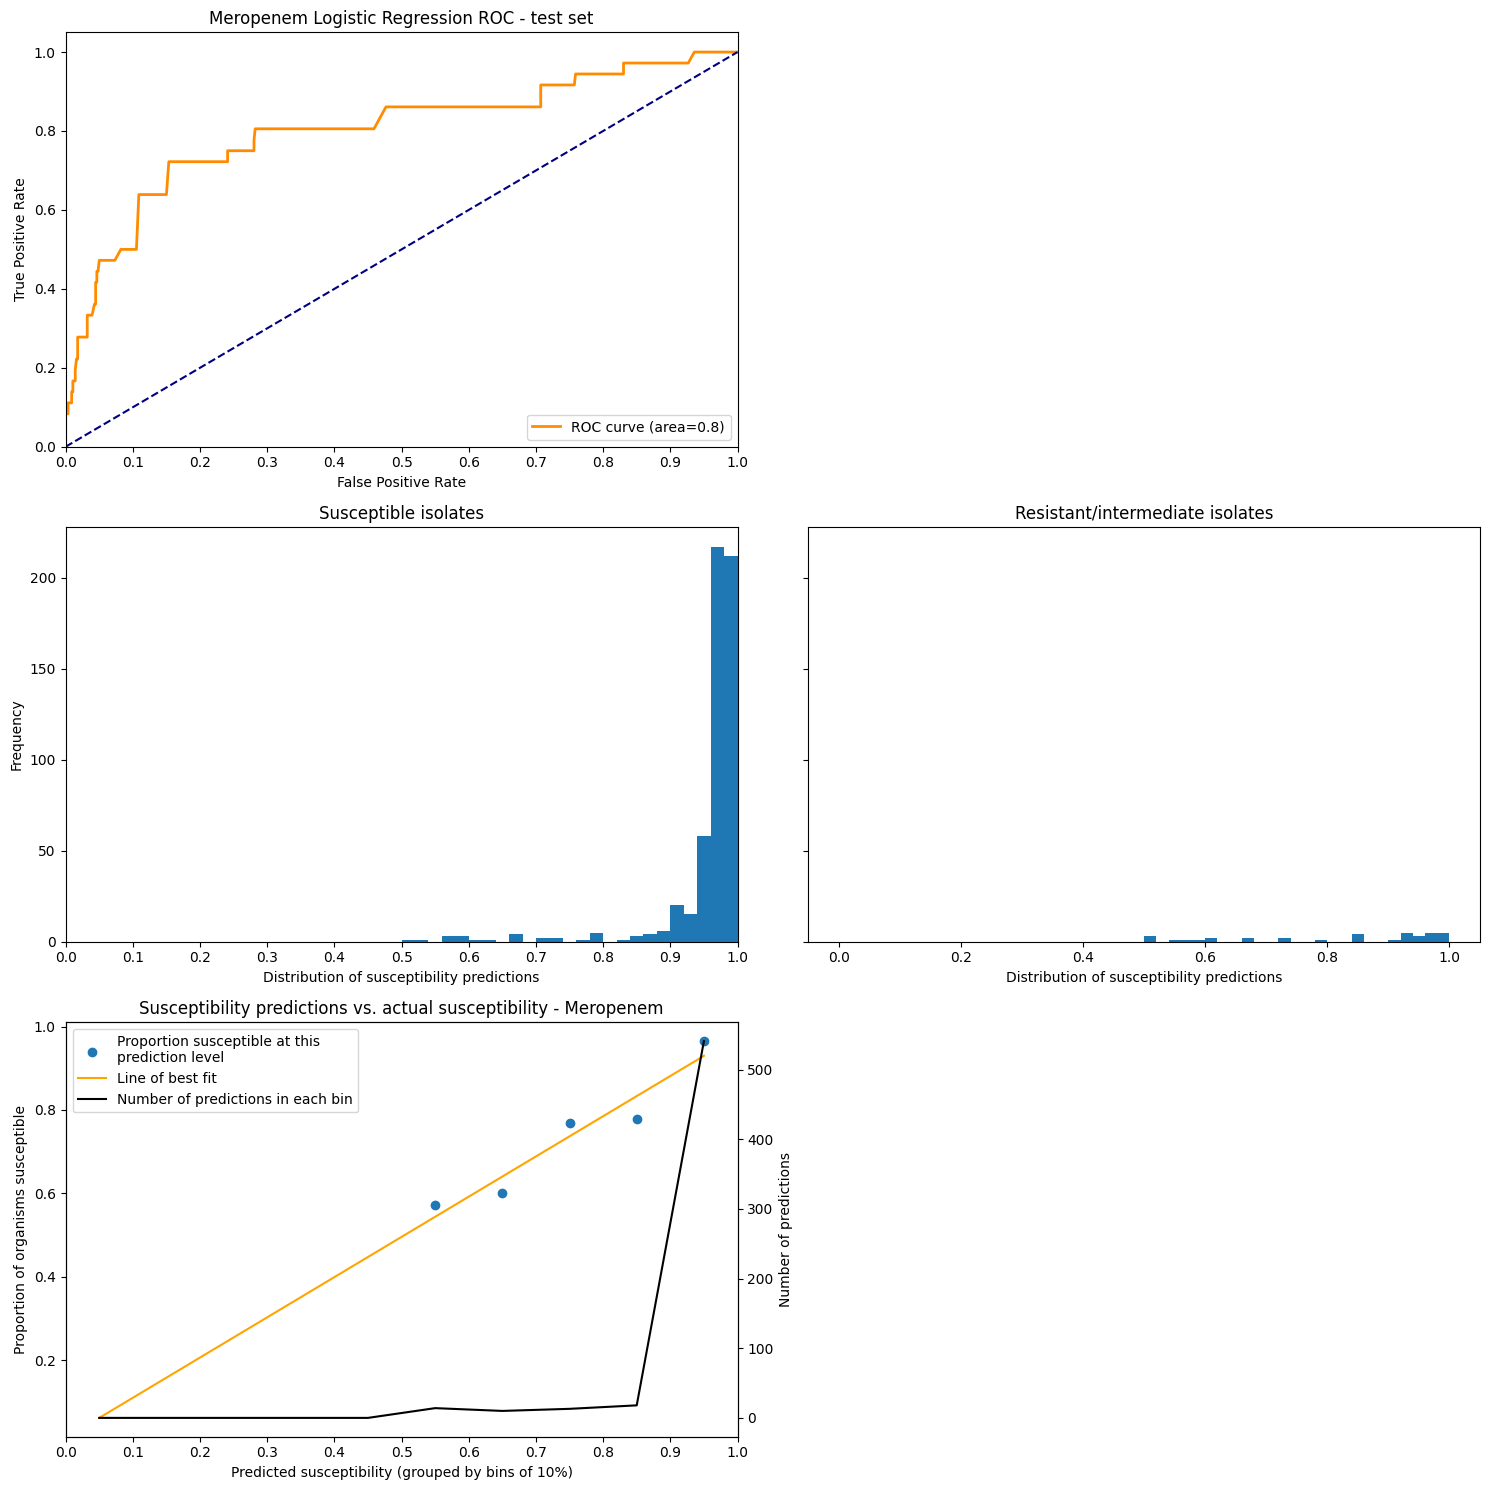


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
CiprofloxacinResistance_nonsusceptible      1.6161
PriorFQ                                     1.0726
ClinicalESBL                                1.0665
sex_M                                       0.3274
age_40-45                                   0.1996
acquisition_ward                            0.1851
acquisition_ICU                             0.0213
hosp_Sunnybrook                             0.0000
hosp_TOH                                    0.0000
RecentHospitalization                      -0.0034
age_80-85                                  -0.0274
age_45-50                                  -0.1433
age_55-60                                  -0.1541
adm_service_surgical                       -0.1612
age_75-80                                  -0.2140
CiprofloxacinResistance_susceptible        -0.2807
age_65-70                                  -0.2817
age_70-75                                  -0.2864
ag

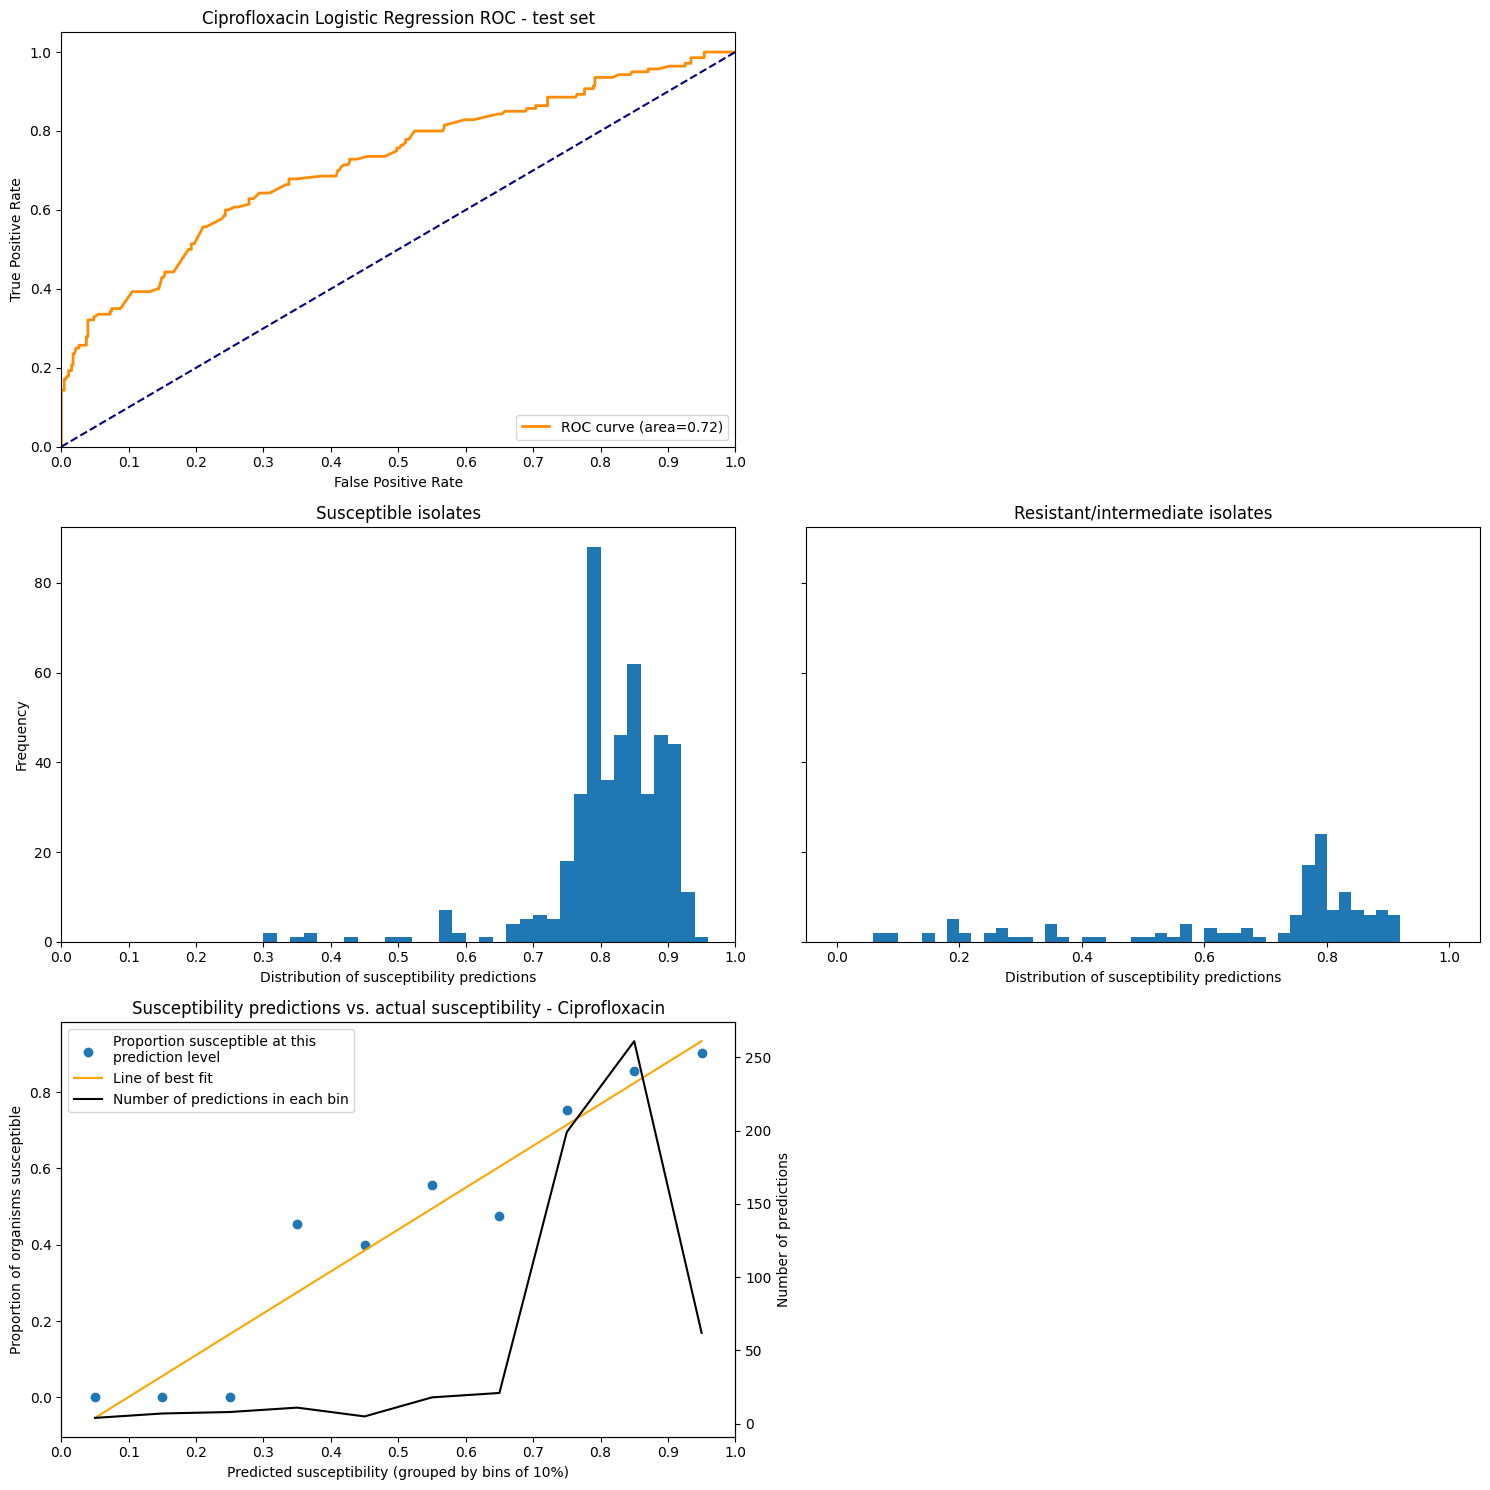


Logistic regression model for Tobramycin:

Logistic Regression Coefficients
TobramycinResistance_nonsusceptible         2.0012
ClinicalESBL                                0.6848
PriorAMG                                    0.5210
sex_M                                       0.4635
age_60-65                                   0.3116
age_55-60                                   0.2718
age_65-70                                   0.2334
age_80-85                                   0.2238
age_75-80                                   0.1708
RecentHospitalization                       0.1478
acquisition_ICU                             0.1142
PriorNonAMG                                 0.0866
age_50-55                                   0.0390
age_85-90                                   0.0298
age_45-50                                   0.0276
age_70-75                                   0.0057
acquisition_ward                            0.0050
hosp_Sunnybrook                             0.0001
hosp_

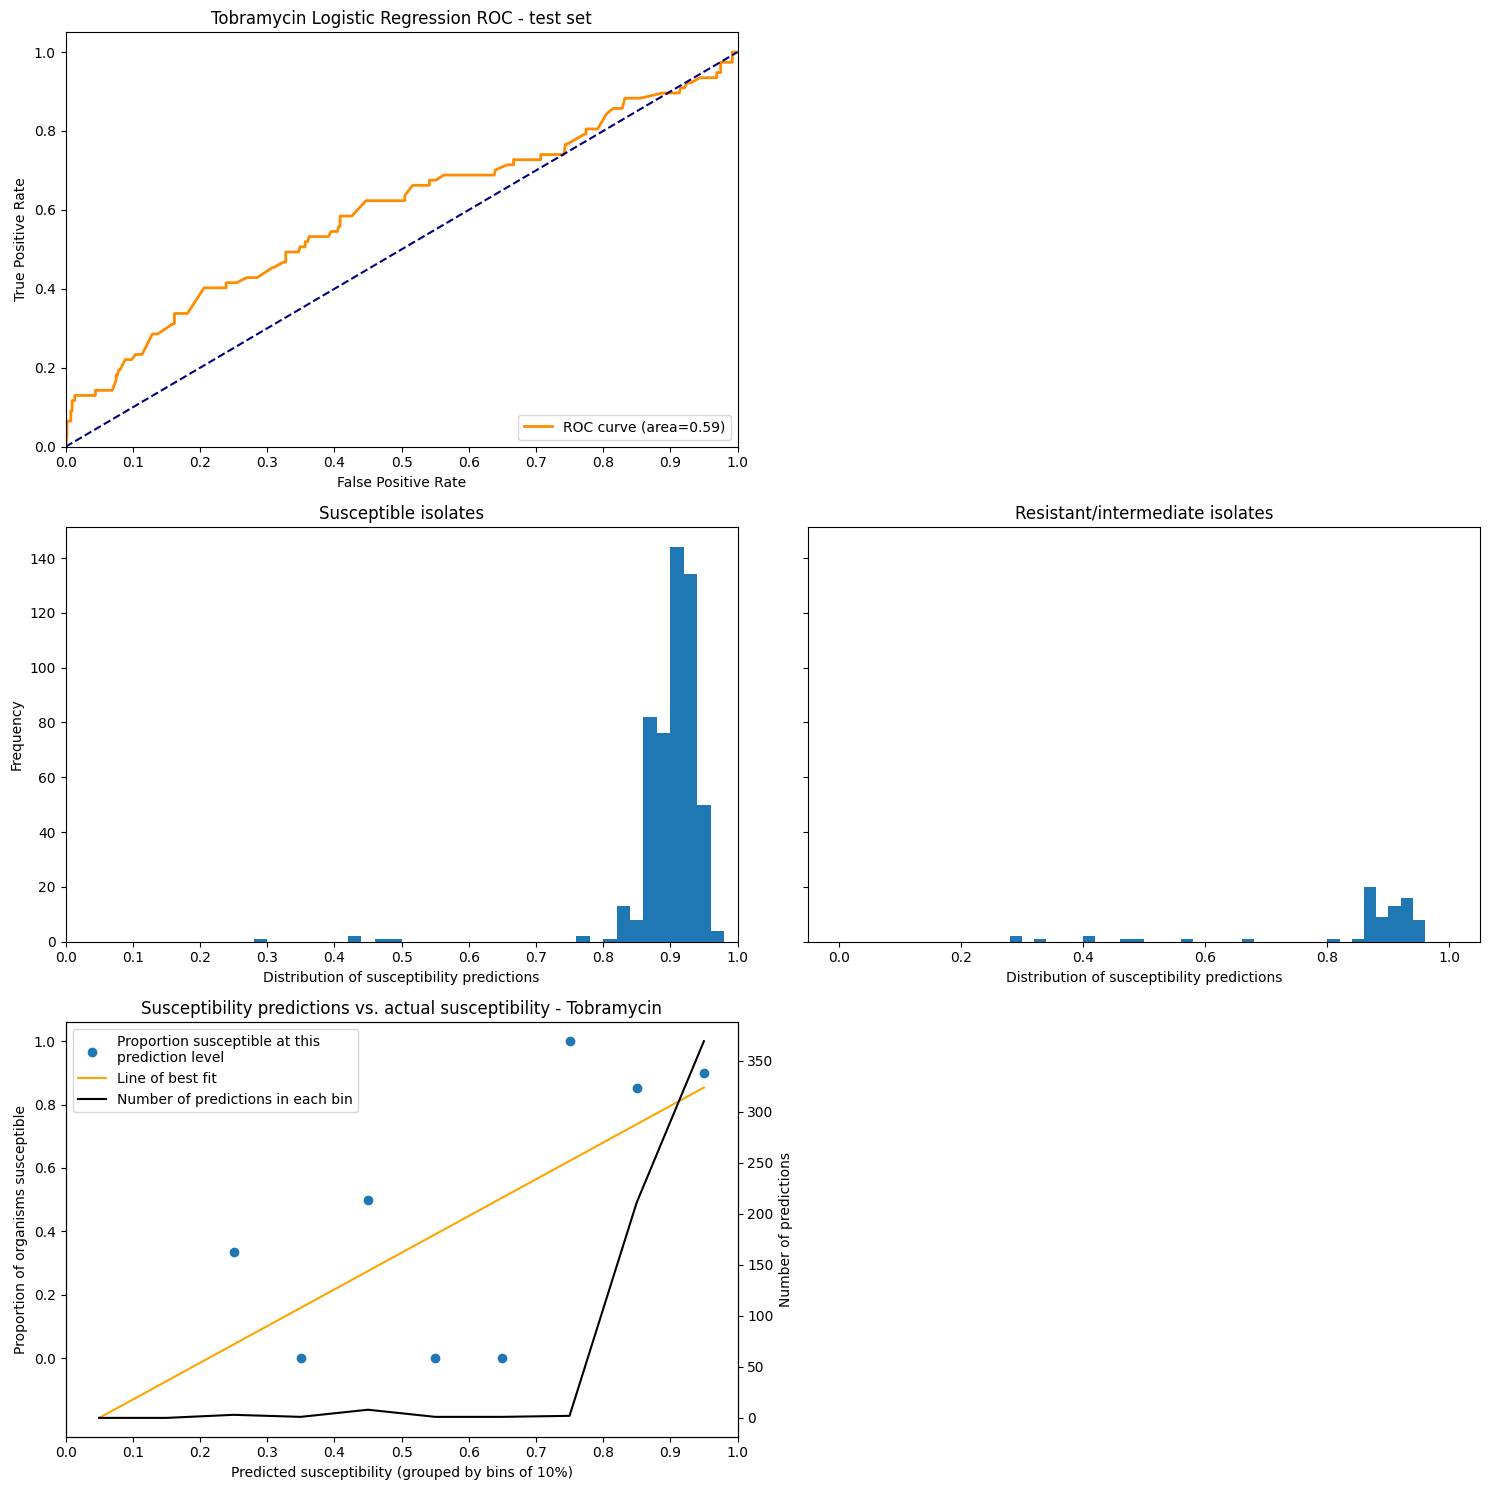


Logistic regression model for TMPSMX:

Logistic Regression Coefficients
TMPSMXResistance_nonsusceptible             1.9329
ClinicalESBL                                0.6304
PriorNonOtherAbx                            0.2606
acquisition_ICU                             0.2405
PriorOtherAbx                               0.2271
adm_service_surgical                        0.1968
sex_M                                       0.0966
age_55-60                                   0.0279
acquisition_ward                            0.0046
hosp_Sunnybrook                             0.0001
hosp_TOH                                    0.0000
RecentHospitalization                      -0.0719
age_40-45                                  -0.1469
age_50-55                                  -0.2493
TMPSMXResistance_susceptible               -0.3254
age_45-50                                  -0.3467
ICUExposure                                -0.3693
age_70-75                                  -0.3694
age_80-85

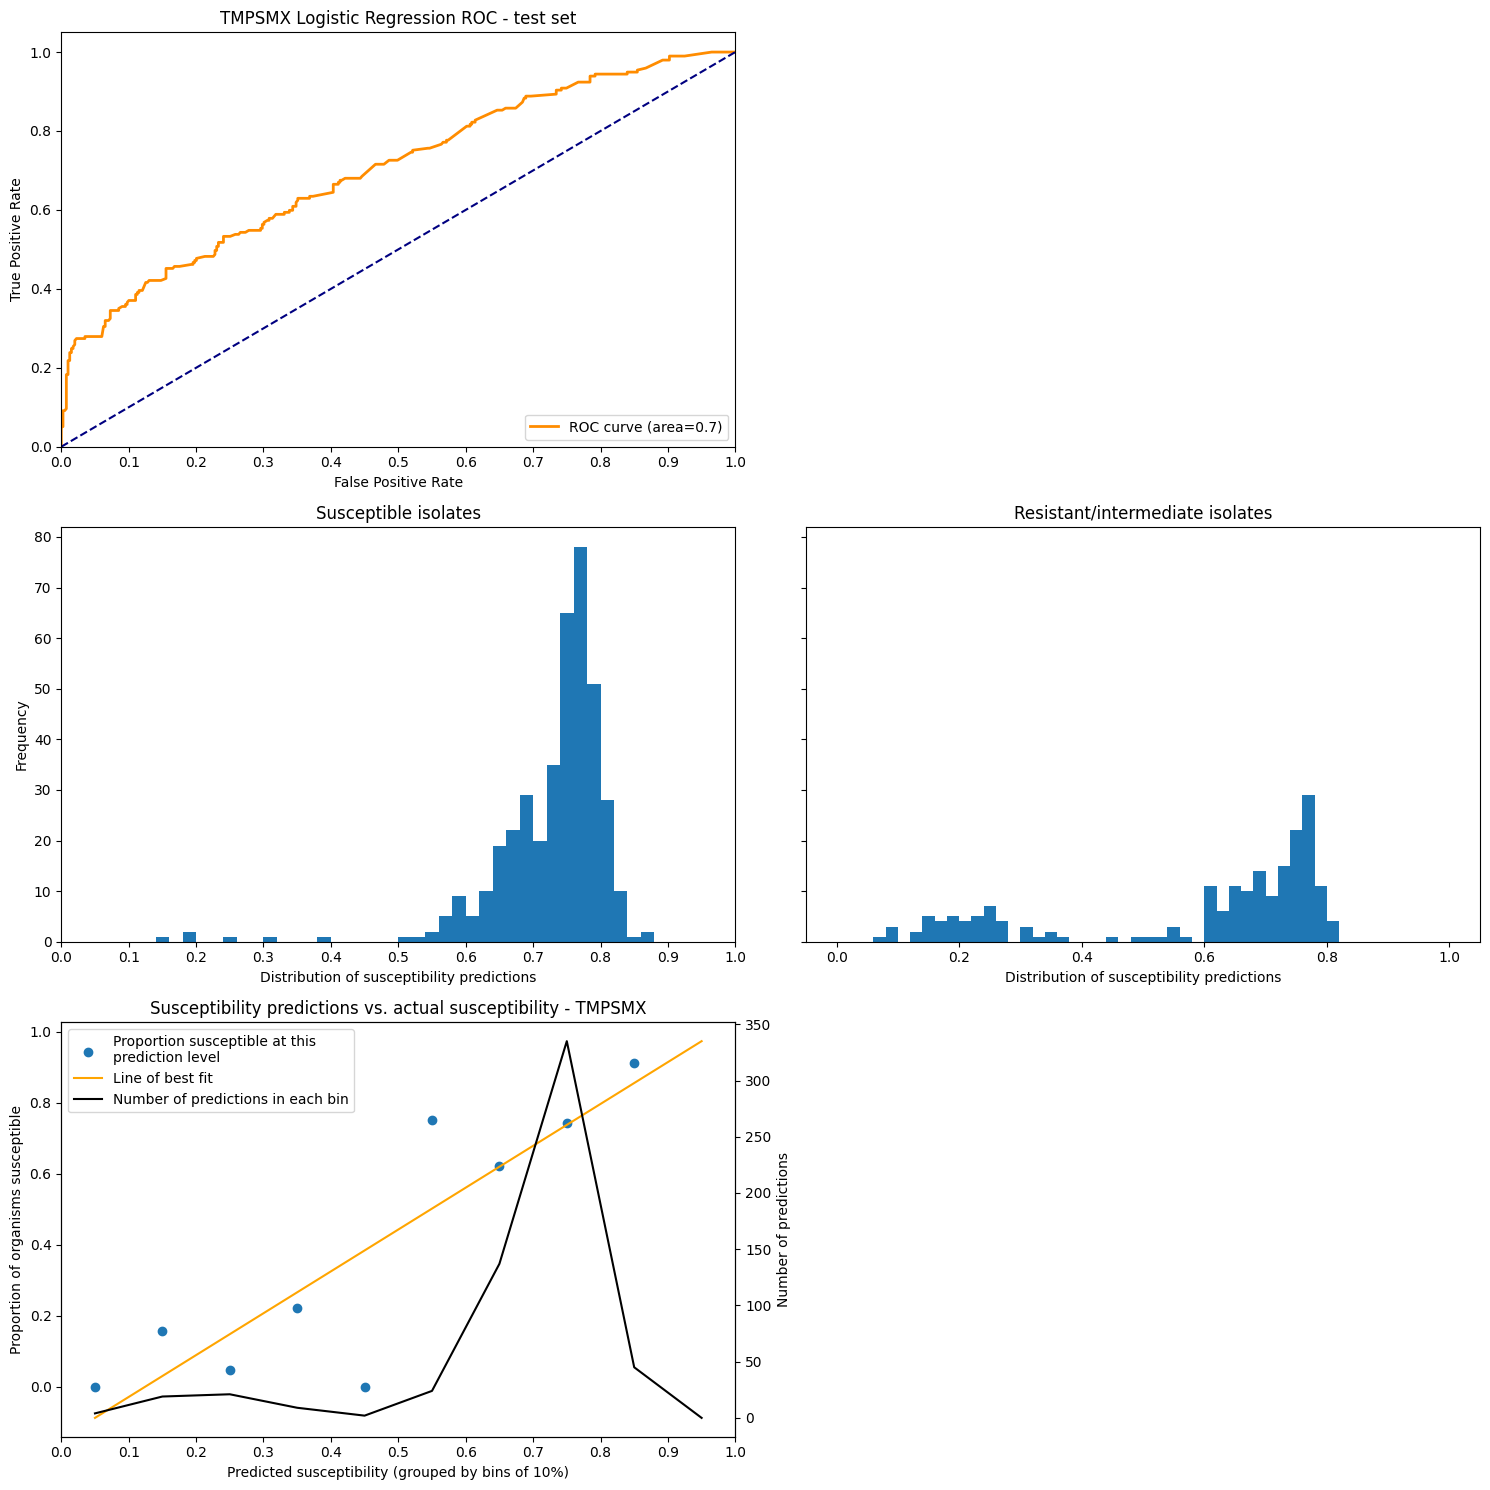


Logistic regression model for Piptaz_or_Tobramycin:

Logistic Regression Coefficients
Piptaz_or_TobramycinResistance_susceptible  1.6823
Piptaz_or_TobramycinResistance_nonsusceptible  0.9033
ClinicalESBL                                0.8556
age_60-65                                   0.4971
acquisition_ICU                             0.4683
PriorNonPenicillin_or_AMG                   0.3895
age_55-60                                   0.3820
age_45-50                                   0.2790
age_65-70                                   0.2777
sex_M                                       0.2575
RecentHospitalization                       0.1813
age_75-80                                   0.1173
age_40-45                                   0.0515
hosp_Sunnybrook                             0.0004
hosp_TOH                                    0.0000
age_80-85                                  -0.0049
age_85-90                                  -0.0288
age_50-55                                  

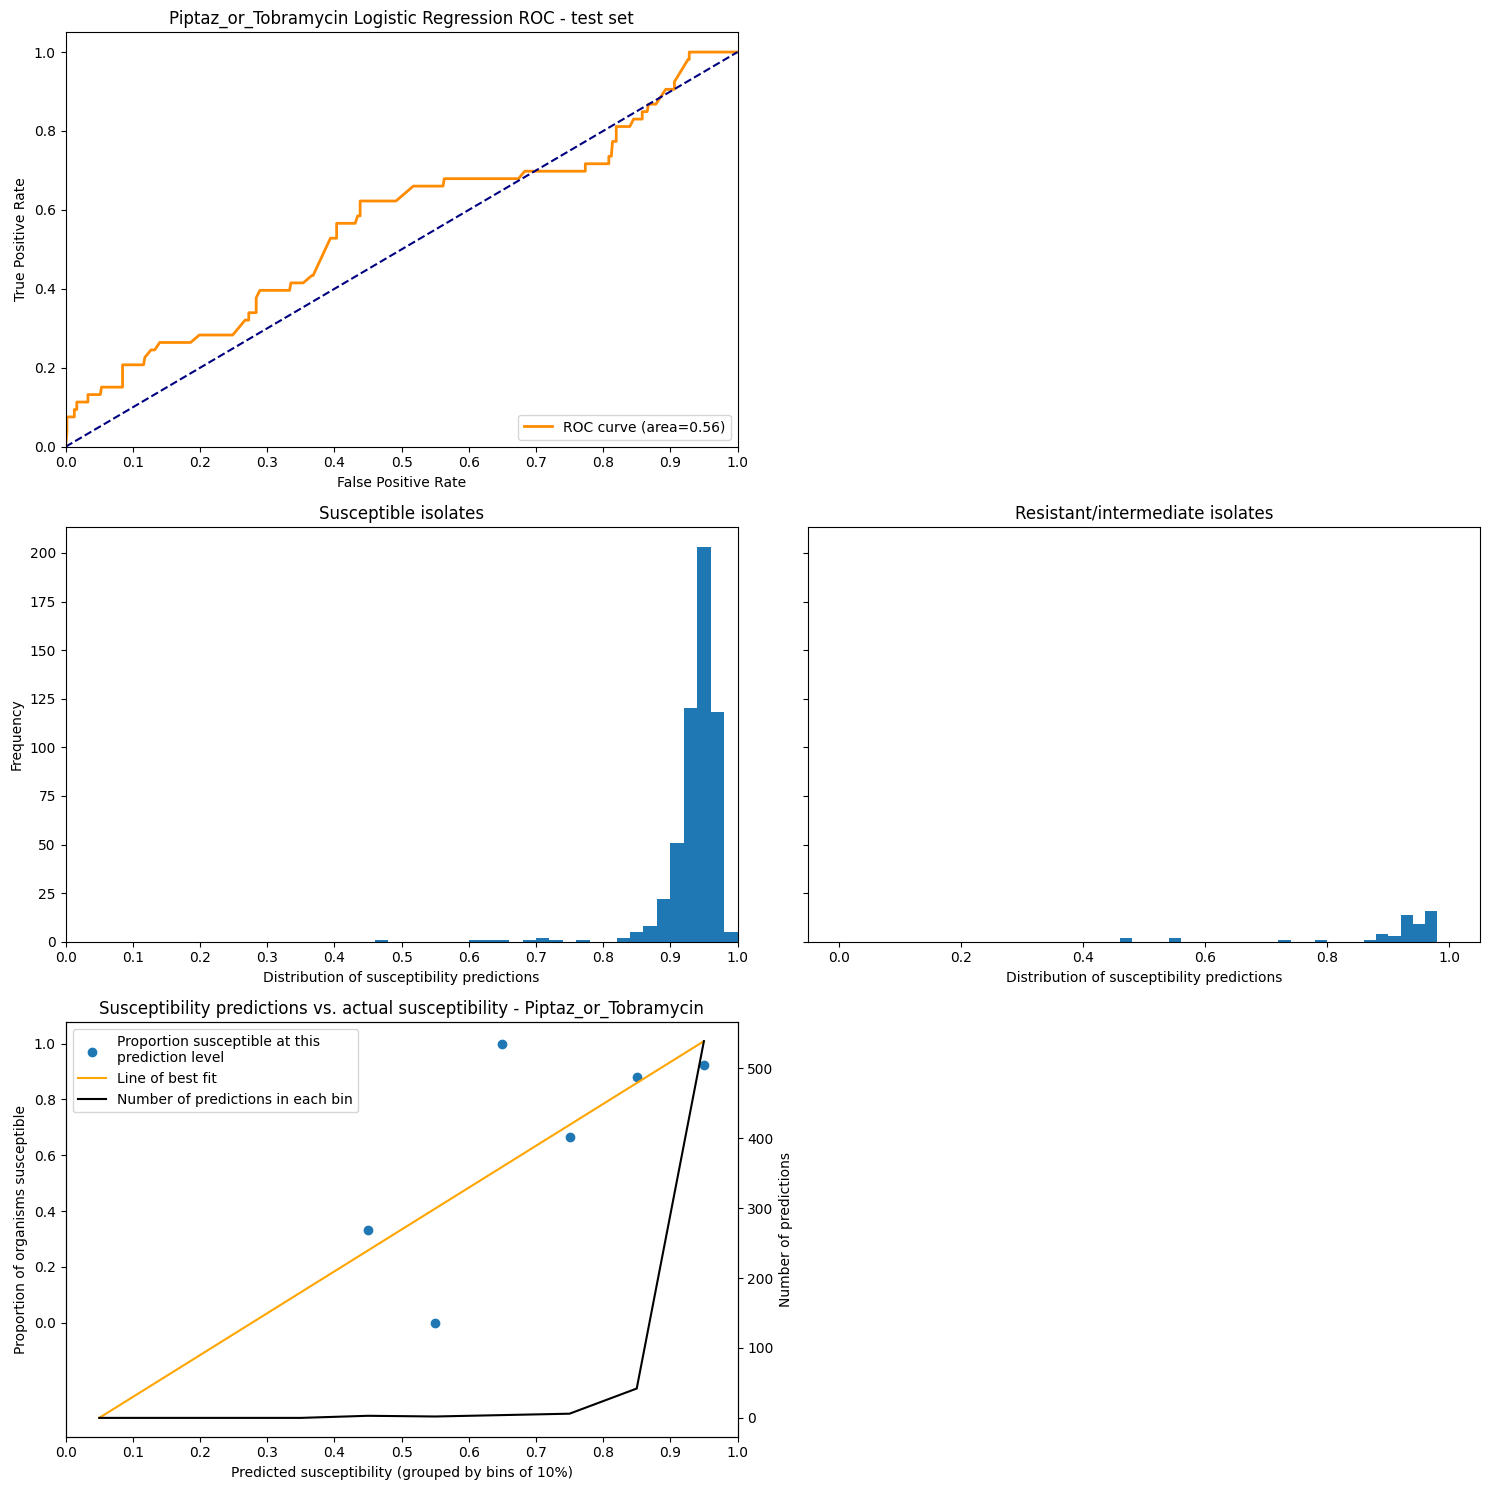

In [17]:
# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(one_hot_data, [int(.8 *len(one_hot_data))])

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    regression_inputs = ['hosp_Sunnybrook','hosp_TOH', 
                         'age_40-45','age_45-50','age_50-55','age_55-60',
                         'age_60-65','age_65-70','age_70-75','age_75-80',
                         'age_80-85','age_85-90','age_>90',
                         'sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization','ICUExposure',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    # 0 = susceptible, 1 = resistant
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression(max_iter=200)
    reg.fit(X_train,Y_train)
    
    # Save the regression model to pickle
    # with open(antibiotic+'.pickle','wb') as reg_file:
    #     pickle.dump(reg,reg_file)
        
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    print('Mean predicted susceptibility of all isolates: {:.2f}'.format(np.mean(list(i[0] for i in predict_results))))

    
    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))

    '''
    # Calculate and plot ROC based on train set    
    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
    '''
    ax[0,1].axis('off') # Delete this line if we want to see above plot
    
    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates, bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates, bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    

    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Writing the regression model (with _all_ data) to file

In [18]:
for antibiotic in antibiotic_list:

    regression_inputs = ['hosp_Sunnybrook','hosp_TOH', 
                         'age_40-45','age_45-50','age_50-55','age_55-60',
                         'age_60-65','age_65-70','age_70-75','age_75-80',
                         'age_80-85','age_85-90','age_>90',
                         'sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization','ICUExposure',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']

    reg = linear_model.LogisticRegression(max_iter=200)
    reg.fit(one_hot_data[regression_inputs],one_hot_data[antibiotic+'_FINAL_imp'])

    # Save the regression model to pickle
    with open(antibiotic+'.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)

## Quality assurance of the model on previous isolates

In [19]:
QA_data = one_hot_data
for antibiotic in antibiotic_list:
    with open(antibiotic+'.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['hosp_Sunnybrook','hosp_TOH', 
                         'age_40-45','age_45-50','age_50-55','age_55-60',
                         'age_60-65','age_65-70','age_70-75','age_75-80',
                         'age_80-85','age_85-90','age_>90',
                         'sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization','ICUExposure',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = QA_data[regression_inputs]

    QA_data['Predicted'+antibiotic+'Susceptibility'] = reg.predict_proba(regression_values)[:,0]

QA_data.to_excel('2024-03-24 QA data.xlsx')